# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2
import time
startTime=time.time()
import os
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

import numpy as np

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models, optimizers, callbacks

from notebooks.utils import display, sample_batch #书作者自编模块

## 0. Parameters <a name="parameters"></a>

In [2]:
#可调参数
BATCH_SIZE = 16 #N_FILTERS = 256取32，N_FILTERS = 128取64。原始值128.查看显存占用比例“nvidia-smi”。
EPOCHS =80 #原始值150
RESIDUAL_BLOCKS = 10 #有几个ResidualBlock层堆叠，原始值5
N_FILTERS = 512 #过滤器数目（神经元数目），原始值128
B_MaskedConv2D_BLOCKS=2 #有几个B_MaskedConv2D层堆叠，原始值2
learning_rate=0.001 #原始值0.0005
temperature=1  #理论上取(0,1]之间，越大越随机、越小越确定。但是这里取小会导致空白多，故取大值。原始值1
num_img=20

#固定参数
IMAGE_SIZE =  (48, 192) #再小清晰度就不满足了
CHANNELS = 1
PIXEL_LEVELS = 10 #原始PIXEL_LEVELS =4，像素值0~1划分为0、0.25、0.5、0.75四种数值。标签的种类。取255对计算速度影响很小。原始值4，导致图像内容缺失过多，测试发现PIXEL_LEVELS = 10不再出现内容缺失了.
train_dir=".\\png 192x48_GRAY\\" #文件名字符数目不能过多，否则出错，故在旋转、缩放、平移变换时减少文件名字符。
steps_per_epoch=math.ceil(9600/BATCH_SIZE)  #文件总数9600。math.ceil() 对浮点数向上取整。

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
#加载数据集，P108
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
                                                    train_dir, #各个子目录自动打乱的，某个子目录中文件也是打乱的
                                                    target_size=IMAGE_SIZE,
                                                    color_mode="grayscale",
                                                    batch_size=9600, #文件总数9600，一次加载全部
                                                    class_mode="sparse" #返回1D的整数标签
                                                    )


for data_batch, labels_batch in train_generator:
    print('data_batch.shape:', data_batch.shape)#data batch shape: (9600, 48, 192, 1)
    print('labels_batch.shape:', labels_batch.shape)#labels batch shape: (9600,)
    break



Found 9600 images belonging to 8 classes.
data_batch.shape: (9600, 48, 192, 1)
labels_batch.shape: (9600,)


In [4]:
def preprocess(imgs_int):
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int
input_data, output_data = preprocess(data_batch)

print('input_data.shape:', input_data.shape)
print('output_data.shape:', output_data.shape)

input_data.shape: (9600, 48, 192, 1)
output_data.shape: (9600, 48, 192, 1)


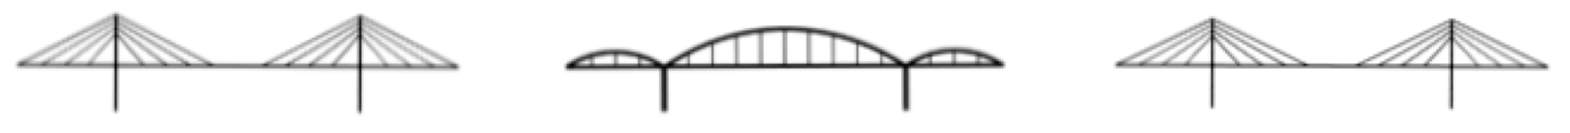

In [5]:
np.savetxt('data_batch[0].txt', data_batch[0][:,:,0],fmt='%.3f')  #像素值0~255
display(data_batch, n=3)

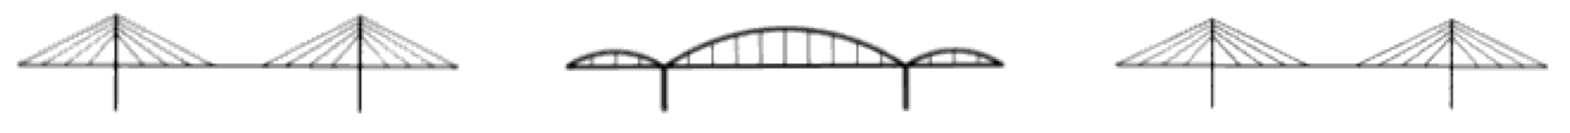

In [6]:
np.savetxt('output_datale[0].txt', output_data[0][:,:,0],fmt='%.3f')
display(output_data, n=3)

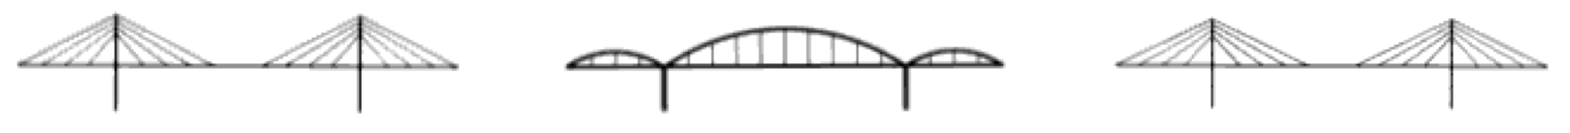

In [7]:
np.savetxt('input_data[0].txt', input_data[0][:,:,0],fmt='%.3f')
display(input_data, n=3)

## 2. Build the PixelCNN

In [8]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer): #本class先运行卷积核掩码运算、再Conv2D操作
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__() #python2必须写成 super（子类名，self）.方法名（参数）;python3 可以直接写成 super().方法名（参数）
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape() #详见“tensorflow原生代码tf.conv2d kernel卷积运算实例.pdf”。kernel_shape[0]为窗口行数、kernel_shape[0]为窗口列数
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0 #" / "浮点数除法3/2=1.5;      " // "整数除法3//2=1
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0 #切片操作[10:100]是不含100的
        if self.mask_type == "B": #类型A，中心像素的值也加以掩膜；类型B，中心像素的值不加掩膜
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs): #本class的函数式调用，先运行卷积核掩码运算、再Conv2D操作
        self.conv.kernel.assign(self.conv.kernel * self.mask) #“.assign()”是tf变量赋值的方法
        return self.conv(inputs) #进行Conv2D操作

    def get_config(self): #《python深度学习第二版》P305
        cfg = super().get_config()
        return cfg

In [9]:
class ResidualBlock(layers.Layer): #残差块
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs): #inputs是(a,b,filters)形状图像，filters为通道数
        x = self.conv1(inputs) #Conv2D操作，输出尺寸为(a,b,filters//2)
        x = self.pixel_conv(x) #“掩码运算+Conv2D操作”，输出尺寸为(a,b,filters//2)
        x = self.conv2(x) #Conv2D操作，输出尺寸为(a,b,filters)
        return layers.add([inputs, x]) #inputs与x的形状完全相同。inputs在输入前已做过“掩码运算+Conv2D操作”

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [10]:
inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS): #多个ResidualBlock 层堆叠
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(B_MaskedConv2D_BLOCKS):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1, #kernel_size=1、mask_type="B"时，此时卷积核窗口尺寸（1，1，通道数）、最右上角掩码值为1，故相当于dense层运算了（通道叠加一起运算）。
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax", #将多分类的结果以概率的形式展现出来，各种预测结果概率之和等于1。概率最大的索引作为预测类别来计算损失
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out) #从头至尾图像像素尺寸未变化过，变化的是通道数（通道数：输入1、输出4、中间128、残差块内部64）
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 192, 1)]      0         
                                                                 
 masked_conv2d (MaskedConv2D  (None, 48, 192, 512)     25600     
 )                                                               
                                                                 
 residual_block (ResidualBlo  (None, 48, 192, 512)     852992    
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 48, 192, 512)     852992    
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 48, 192, 512)     852992    
 lock)                                                       

## 3. Train the PixelCNN <a name="train"></a>

In [11]:
adam = optimizers.Adam(learning_rate=learning_rate)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy") #损失函数取sparse_categorical_crossentropy整数格式时，代码是将神经网络最后一层输出的向量，取其最大值索引作为预测标签，然后与样本真实标签相减

In [12]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img,temperature):
        self.num_img = num_img
        self.temperature=temperature

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs) #默认size=None，返回单个值。p为概率分布，表示a（=len(probs)）中的元素抽取概率。len(probs)=4，返回0、1、2、3四种数值。

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape #shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)，故单通道

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels): #shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)，故单通道
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ] #模型预测结果是：某行某列像素的“4种类别概率（0~1之间）”
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ] #这里x是某个样本的：某行某列像素的“4种类别概率（0~1之间）”。self.sample_from()方法返回值是类别（0、1、2、3四种数值）
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS #像素值由像素类别（0、1、2、3四种数值）转换为0、0.25、0.5、0.75

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=self.temperature)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=1,temperature=temperature)

In [13]:
history=pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=[tensorboard_callback, img_generator_callback],
)

Epoch 1/80
600/600 [==============================] - 446s 733ms/step - loss: 0.1821
Epoch 2/80
600/600 [==============================] - 440s 733ms/step - loss: 0.0838
Epoch 3/80
600/600 [==============================] - 440s 733ms/step - loss: 0.0668
Epoch 4/80
600/600 [==============================] - 440s 733ms/step - loss: 0.0646
Epoch 5/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0583
Epoch 6/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0551
Epoch 7/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0488
Epoch 8/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0465
Epoch 9/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0463
Epoch 10/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0433
Epoch 11/80
600/600 [==============================] - 439s 732ms/step - loss: 0.0423
Epoch 12/80
600/600 [==============================] - 439s 732

In [14]:
#自加代码
pixel_cnn.save("./models") #可行
endTime=time.time()
print('How many minutes:',(endTime-startTime)/60)  #586m/512神经元/RESIDUAL_BLOCKS = 10/80轮。GPU训练速度很快的，但是生成图像速度奇慢。CPU速度更慢（训练、推理）。

INFO:tensorflow:Assets written to: ./models\assets


INFO:tensorflow:Assets written to: ./models\assets


How many minutes: 585.5468013246854


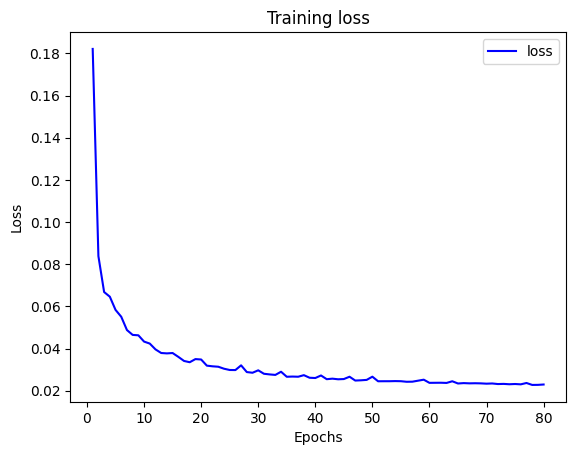

In [15]:
with open('history.history.txt', 'w') as file_object:
    file_object.write(str(history.history)+'\n')  #损失写入文件

history_dict = history.history
loss = history_dict['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 4. Generate images <a name="generate"></a>


Saved to ./output/generated_img_a.png


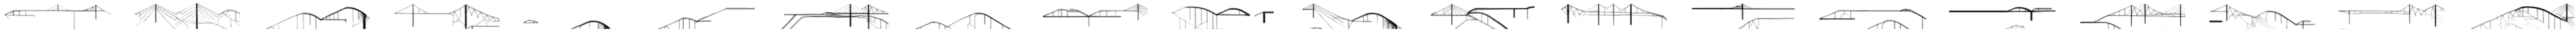

How many minutes: 62.163792192935944
(20, 48, 192, 1)


In [16]:
def sample_from(probs, temperature):  
    probs = probs ** (1 / temperature)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs) #默认size=None，返回单个值。p为概率分布，表示a（=len(probs)）中的元素抽取概率。len(probs)=4，返回0、1、2、3四种数值。

def generate(num_img,temperature):
    generated_images = np.zeros(
        shape=(num_img,) + (pixel_cnn.input_shape)[1:]
    )
    batch, rows, cols, channels = generated_images.shape #shape=(IMAGE_SIZE, IMAGE_SIZE, 1)，故单通道

    for row in range(rows):
        for col in range(cols):
            for channel in range(channels): #shape=(IMAGE_SIZE, IMAGE_SIZE, 1)，故单通道
                probs = pixel_cnn.predict(generated_images, verbose=0)[
                    :, row, col, :
                ] #模型预测结果是：某行某列像素的“4种类别概率（0~1之间）”
                generated_images[:, row, col, channel] = [
                    sample_from(x, temperature) for x in probs
                ] #这里x是某个样本的：某行某列像素的“4种类别概率（0~1之间）”。self.sample_from()方法返回值是类别（0、1、2、3四种数值）
                generated_images[:, row, col, channel] /= PIXEL_LEVELS #像素值由像素类别（0、1、2、3四种数值）转换为0、0.25、0.5、0.75

    return generated_images


startTime=time.time()
generated_images = generate(num_img,temperature)
display(generated_images, n=num_img,size=(160, 2),save_to="./output/generated_img_a.png") #之前gan模型经验size=(160, 2)这种比例清晰度高
endTime=time.time()
print('How many minutes:',(endTime-startTime)/60) #20张图片62m.CPU速度更慢（训练、推理）。
#np.savetxt(os.path.join("./output/", 'generated_images[0].txt'), generated_images[0][:,:,0],fmt='%.3f')  #像素值0~1

for i in range(num_img):
    img = image.array_to_img(abs(generated_images[i]*255.0-255), scale=False) #scale设置为false，否则灰度可能会发生变化。
    img.save(os.path.join("./output/generated_images", 'generated_images_a%d.png'%i)) #要保持值不变，请以png格式。jpg文件值不同（压缩了图像）
print(generated_images.shape)